In [45]:
import numpy as np
import pyvisa as visa
import time
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
rm = visa.ResourceManager()

In [3]:
rm.list_resources()

('USB0::0x0699::0x0368::C017059::INSTR',
 'USB0::0x0699::0x0353::1915264::INSTR',
 'ASRL1::INSTR',
 'ASRL10::INSTR')

In [4]:
resource_name_f=  'USB0::0x0699::0x0353::1915264::INSTR'
resource_name_o = 'USB0::0x0699::0x0368::C017059::INSTR'

osci = rm.open_resource(resource_name_o)
fungen = rm.open_resource(resource_name_f)

In [5]:
osci.query('*IDN?')

'TEKTRONIX,TBS 1052B-EDU,C017059,CF:91.1CT FV:v3.25\n'

In [6]:
fungen.query('*IDN?')

'TEKTRONIX,AFG1022,1915264,SCPI:99.0 FV:V1.2.4\n'

In [42]:
def barrido_v(v_min,v_max,n,folder,scale='lin',autoset=True):
    if scale == 'log':
        volts = np.logspace(v_min,v_max,n)
    elif scale == 'lin':
        volts = np.linspace(v_min,v_max,n)
    else:
        print('Escala inválida')
        return
    time_s = time.time()
    for volt in volts:
        fungen.write(f'SOURCE1:VOLT {volt}')
        time.sleep(1)
        if autoset:
            osci.write('AUTOS exec')
        time.sleep(6)
        osci.write('DAT:SOU CH1')
        xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
        
        osci.write('ACQ:STATE STOP')
        yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
        osci.write('DAT:SOU CH2')
        yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
        
        osci.write('DAT:ENC RPB')
        osci.write('DAT:WID 1')
        
        osci.write("DAT:SOU CH1")
        data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
        osci.write("DAT:SOU CH2")
        data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
        tiempo = xze + np.arange(len(data1)) * xin
        data1v = (data1 - yoff1) * ymu1 + yze1
        data2v = (data2 - yoff2) * ymu2 + yze2

        osci.write('ACQ:STATE RUN')
        
        df = pd.DataFrame({'t':tiempo,'V_out':data1v,'V_in':data2v})
        plt.plot(df.t,df.V_out,label='out')
        plt.plot(df.t,df.V_in,label='in')
        plt.grid()
        plt.legend(loc=1)
        plt.show()
        df.to_csv(f'plots seke/transistores/{folder}/{np.round(volt,1)}.csv',index=False)

In [38]:
def barrido_f(f_min,f_max,n,folder,scale='lin',autoset=True):
    if scale == 'log':
        freqs = np.logspace(f_min,f_max,n)
    elif scale == 'lin':
        freqs = np.linspace(f_min,f_max,n)
    else:
        print('Escala inválida')
        return
    for freq in freqs:
        fungen.write(f'SOURCE1:FREQ {freq}')
        time.sleep(1)
        if autoset:
            osci.write('AUTOS exec')
        time.sleep(10)
        osci.write('DAT:SOU CH1')
        xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
        
        osci.write('ACQ:STATE STOP')
        yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
        osci.write('DAT:SOU CH2')
        yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
        
        osci.write('DAT:ENC RPB')
        osci.write('DAT:WID 1')
        
        osci.write("DAT:SOU CH1")
        data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
        osci.write("DAT:SOU CH2")
        data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
        tiempo = xze + np.arange(len(data1)) * xin
        data1v = (data1 - yoff1) * ymu1 + yze1
        data2v = (data2 - yoff2) * ymu2 + yze2

        osci.write('ACQ:STATE RUN')
        
        df = pd.DataFrame({'t':tiempo,'V_out':data1v,'V_in':data2v})
        plt.plot(df.t,df.V_out,label='out')
        plt.plot(df.t,df.V_in,label='in')
        plt.grid()
        plt.legend(loc=1)
        plt.show()
        df.to_csv(f'plots seke/transistores/{folder}/{np.round(freq,0)}.csv',index=False)

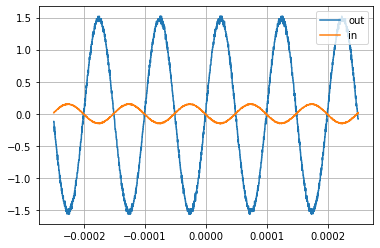

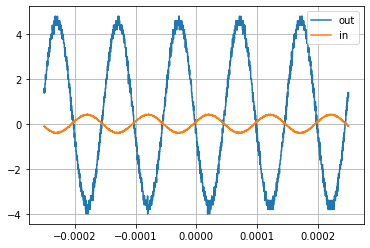

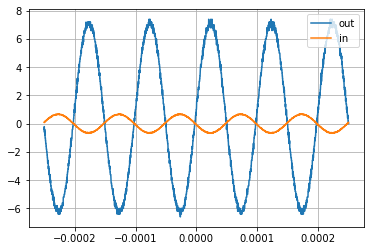

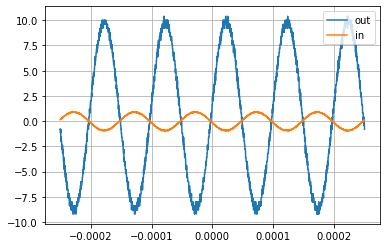

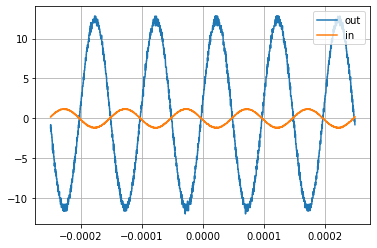

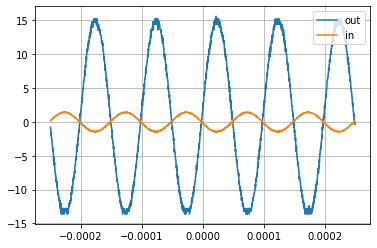

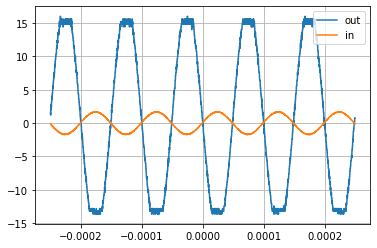

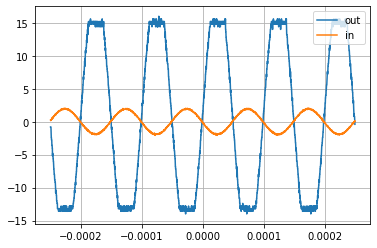

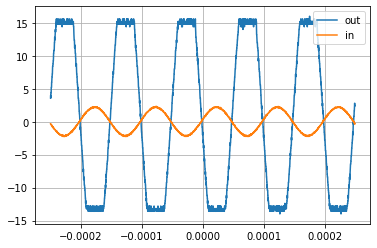

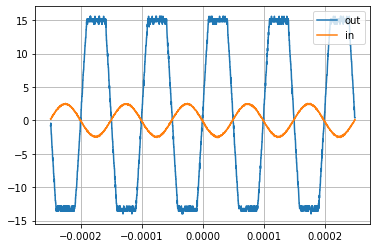

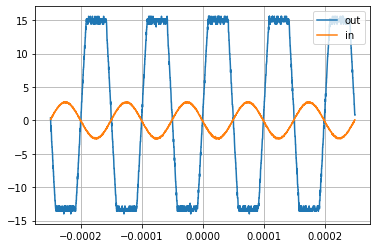

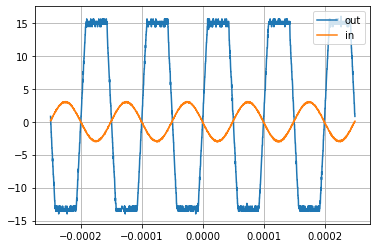

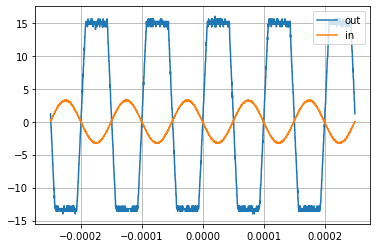

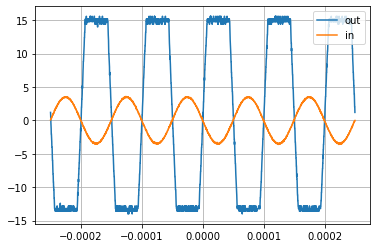

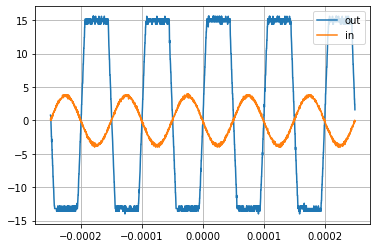

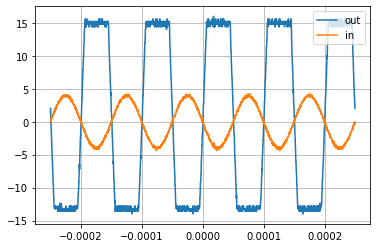

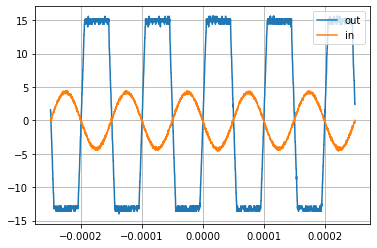

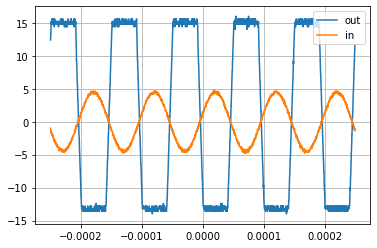

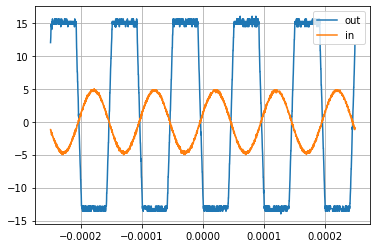

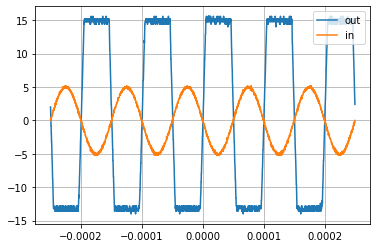

In [44]:
barrido_v(0.3,10,20,'med 0 amp')

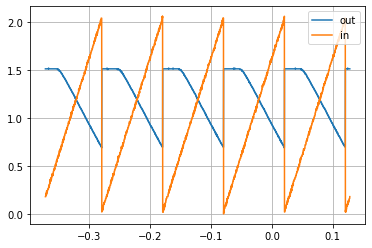

In [89]:
barrido_f(10,10,1,'llave final',autoset=False)

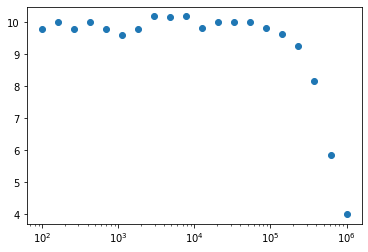

In [80]:
import os
files = os.listdir('plots seke/transistores/med 0 cuadrada')
Vpp_in = []
Vpp_out = []
freqs = []
for file in files:
    freqs.append(float(file[:-4]))
    df = pd.read_csv(f'plots seke/transistores/med 0 cuadrada/{file}')
    Vpp_in.append(max(df.V_in)-min(df.V_in))
    Vpp_out.append(max(df.V_out)-min(df.V_out))
amplificacion = np.array(Vpp_out)/np.array(Vpp_in)
plt.scatter(freqs,amplificacion)
plt.xscale('log')

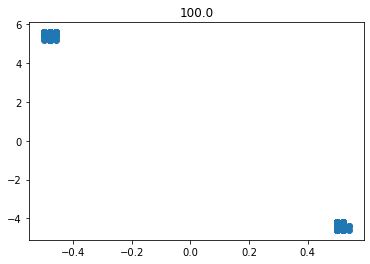

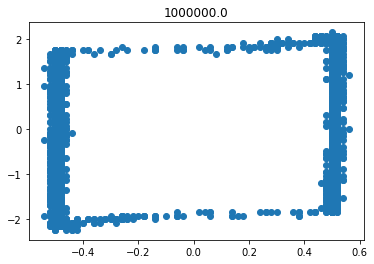

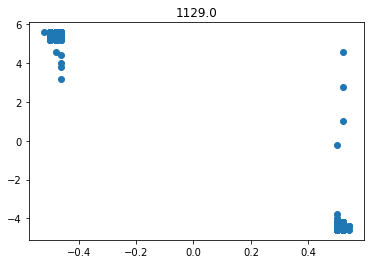

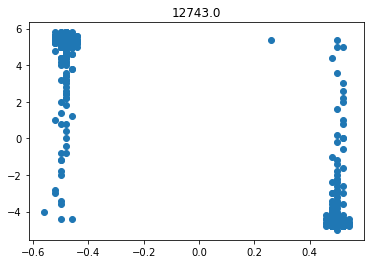

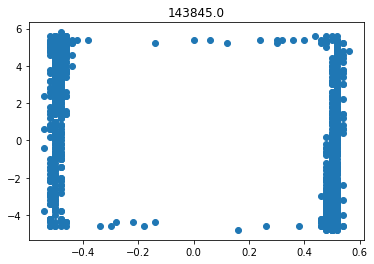

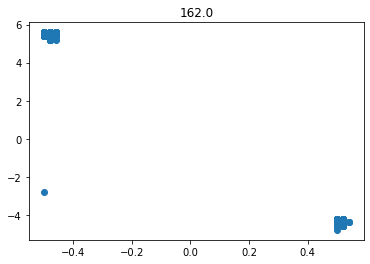

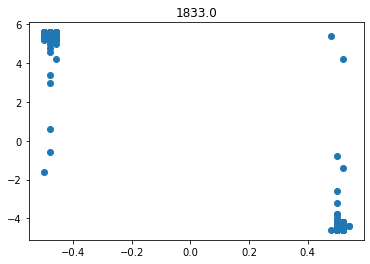

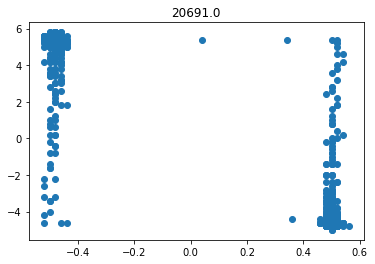

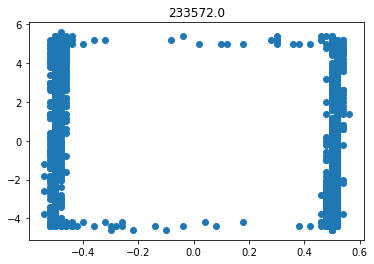

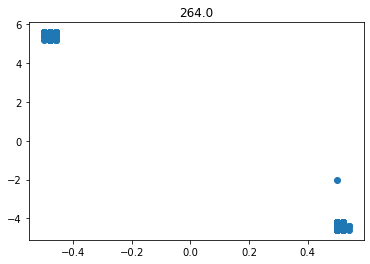

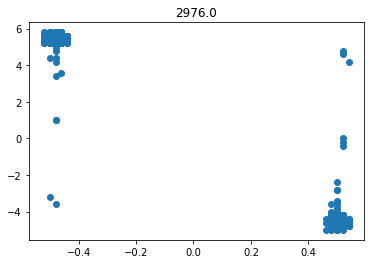

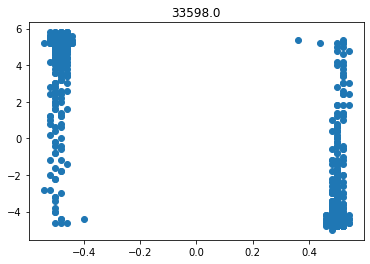

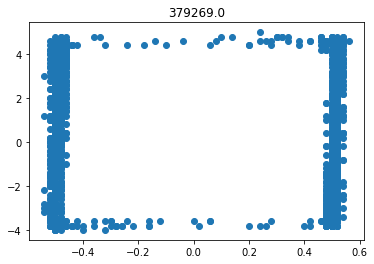

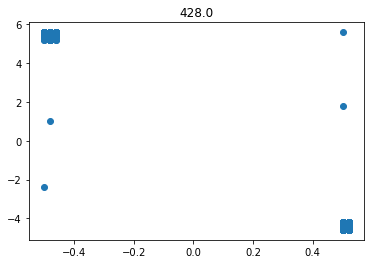

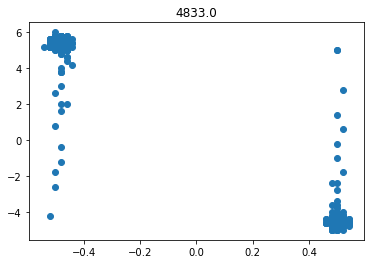

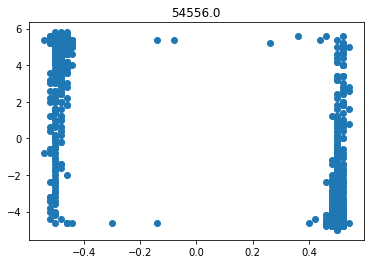

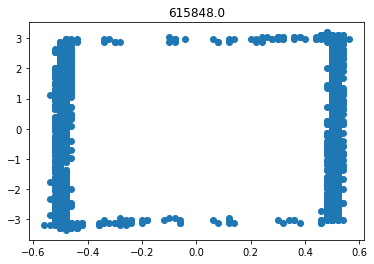

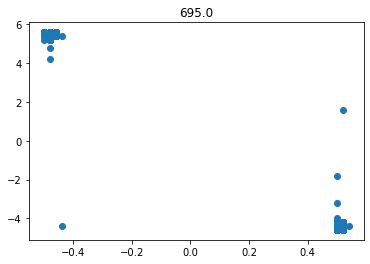

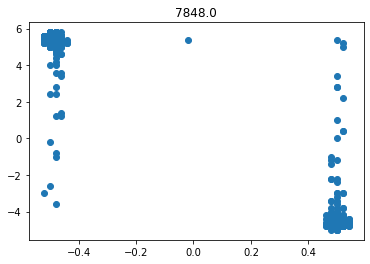

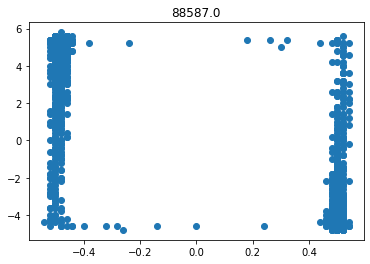

In [73]:
for file in files:
    df = pd.read_csv(f'plots seke/transistores/med 0 cuadrada/{file}')
    plt.scatter(df.V_in,df.V_out)
    plt.title(file[:-4])
    plt.show()